In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthBegin, MonthEnd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import ta
import pandas_ta

In [2]:
import fxcmpy
fxcm_token = 'YOUR_FXCM_TOCKEN'

In [3]:
startdate = '2010-01-01'
enddate = '2022-11-01'
symbol = 'SPX500'
data_dir = '/Users/dplavcan/Documents/ML_project/data/sp500_5min.pickle'

In [4]:
def load_data_from_FXCM(symbol, fxcm_token):
    api = fxcmpy.fxcmpy(access_token=fxcm_token)
    dates = pd.date_range(startdate, enddate, freq='M')
    data = []
    for date in dates:
        t1 = date - MonthBegin(1)
        t2 = date + MonthBegin(1)
        print(f'{t1} - {t2}')
        data.append(
            api.get_candles(symbol, start=t1, end=t2, period='m5').iloc[:-1]
        )
    df = pd.concat(data).asfreq('5min')
    return(df)

In [153]:
if os.path.exists(data_dir):
    print('loading data from saved file')
    df = pd.read_pickle(data_dir)
else:
    print('loading data from fxcm')
    df = load_data_from_FXCM(symbol, fxcm_token)
    df.to_pickle(data_dir)

loading data from saved file


In [154]:
supertrend = pandas_ta.supertrend(
    high=df['bidhigh'],
    low=df['bidlow'],
    close=df['bidclose'],
    length=10, multiplier=3)

In [155]:
def calculate_signals(df, supertrend, window=2):
    
    df[f'rsi_{window}'] = ta.momentum.RSIIndicator(df['bidclose'], window=window).rsi()
    
    df[f'rsi_{window}_signal_80'] = ((df[f'rsi_{window}'] > 80).astype(int).diff()) == 1
    df[f'rsi_{window}_signal_20'] = ((df[f'rsi_{window}'] < 20).astype(int).diff()) == 1
    
    df[f'rsi_{window}_signal_80'] = df[f'rsi_{window}_signal_80'] * (supertrend['SUPERTd_10_3.0'] == 1)
    df[f'rsi_{window}_signal_20'] = df[f'rsi_{window}_signal_20'] * (supertrend['SUPERTd_10_3.0'] == -1)
    
    return(df)

In [156]:
windows = np.arange(2,13,1)
for window in windows:
    print('calculating signals for RSI_' + str(window))
    df = calculate_signals(df, supertrend, window=window)

calculating signals for RSI_2
calculating signals for RSI_3
calculating signals for RSI_4
calculating signals for RSI_5
calculating signals for RSI_6
calculating signals for RSI_7
calculating signals for RSI_8
calculating signals for RSI_9
calculating signals for RSI_10
calculating signals for RSI_11
calculating signals for RSI_12


In [157]:
# calculate trendlength
supertrend['trend_counter'] = (supertrend['SUPERTd_10_3.0'].diff().abs()==2).astype(int).cumsum()
supertrend['trendlength'] = 1
df['trendlength'] = supertrend.groupby('trend_counter')['trendlength'].cumsum()

In [158]:
# dayclose last close value of the day (:= 24 UTC)
dayclose = df['bidclose'].resample('D').last()
dayclose.name = 'dayclose'
df = pd.concat([df, dayclose], axis=1)
df['dayclose'] = df['dayclose'].ffill()

In [159]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [174]:
data_1 = '2022-10-24'
data_2 = '2022-10-28'

rsi_window = '2'

df_plot = df.loc[data_1:data_2]
supertrend_plot = supertrend.loc[data_1:data_2]


# Declare plotly figure (go)
fig=go.Figure()
# add subplot properties when initializing fig variable ***don't forget to import plotly!!!***
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.01, row_heights=[0.5,0.2])


fig.add_trace(go.Candlestick(x=df_plot.index,
                open=df_plot['bidopen'],
                high=df_plot['bidhigh'],
                low=df_plot['bidlow'],
                close=df_plot['bidclose'],
                            name=symbol))

fig.add_trace(go.Scatter(x=supertrend_plot.index, 
                         y=supertrend_plot['SUPERTs_10_3.0'], 
                         opacity=0.7, 
                         line=dict(color='red', width=2), 
                         name='SUPERTs_10_3.0'))

fig.add_trace(go.Scatter(x=supertrend_plot.index, 
                         y=supertrend_plot['SUPERTl_10_3.0'], 
                         opacity=0.7, 
                         line=dict(color='green', width=2), 
                         name='SUPERTl_10_3.0'))

fig.add_trace(go.Scatter(x=df_plot.index, 
                     y=df_plot['rsi_'+rsi_window],
                         name='rsi_'+rsi_window
                    ), row=2, col=1)

fig.add_trace(go.Scatter(x=df_plot.index[df_plot['rsi_'+rsi_window+'_signal_80']], 
                     y=df_plot['rsi_'+rsi_window][df_plot['rsi_'+rsi_window+'_signal_80']],
                        name='rsi_'+rsi_window+'_signal_80',
                        mode='markers',
                        marker = {'color': 'green'},
                    ), row=2, col=1)                 
fig.add_trace(go.Scatter(x=df_plot.index[df_plot['rsi_'+rsi_window+'_signal_20']], 
                     y=df_plot['rsi_'+rsi_window][df_plot['rsi_'+rsi_window+'_signal_20']],
                        name='rsi_'+rsi_window+'_signal_20',
                        mode='markers',
                        marker = {'color': 'red'},
                    ), row=2, col=1)                   



# Update the layout by changing the figure size, hiding the legend and rangeslider
fig.update_layout(height=600,# width=1000, 
                  showlegend=True, 
                  xaxis_rangeslider_visible=False)

fig.show()

In [194]:
window = 2
min_trend_lenght = 36 # number of 5min candels
change_80 = (df.query(
    '(@min_trend_lenght > 36) & (rsi_{}_signal_80 == True)'.format(window)
    )[['bidclose', 'dayclose']].pct_change(axis=1)*100)['dayclose']
change_20 = (df.query(
    '(@min_trend_lenght > 36) & (rsi_{}_signal_20 == True)'.format(window)
    )[['bidclose', 'dayclose']].pct_change(axis=1)*100)['dayclose']

/var/folders/5s/y3c1y8b50qs_9_tsk2nj6fj400027f/T/ipykernel_6871/738212616.py:2: RuntimeWarning:

invalid value encountered in long_scalars

/var/folders/5s/y3c1y8b50qs_9_tsk2nj6fj400027f/T/ipykernel_6871/738212616.py:4: RuntimeWarning:

invalid value encountered in long_scalars

/var/folders/5s/y3c1y8b50qs_9_tsk2nj6fj400027f/T/ipykernel_6871/738212616.py:7: RuntimeWarning:

invalid value encountered in long_scalars

/var/folders/5s/y3c1y8b50qs_9_tsk2nj6fj400027f/T/ipykernel_6871/738212616.py:9: RuntimeWarning:

invalid value encountered in long_scalars



SPX-change > +0.5% after RSI_80 signal: nan %
SPX-change < -0.5% after RSI_20 signal: nan %

SPX-change < -0.5% after RSI_80 signal: nan %
SPX-change > +0.5% after RSI_20 signal: nan %


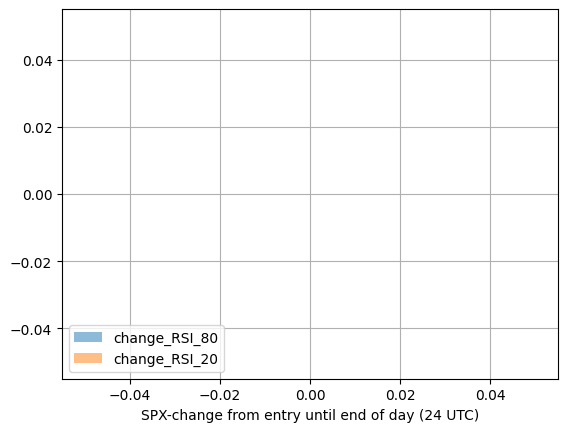

In [196]:
print('SPX-change > +0.5% after RSI_80 signal: ' 
      + str(((change_80 > 0.5).sum() / len(change_80) * 100).round(1)) + ' %')
print('SPX-change < -0.5% after RSI_20 signal: ' 
      + str(((change_20 < -0.5).sum() / len(change_80) * 100).round(1)) + ' %')
print('')
print('SPX-change < -0.5% after RSI_80 signal: ' 
      + str(((change_80 < -0.5).sum() / len(change_80) * 100).round(1)) + ' %')
print('SPX-change > +0.5% after RSI_20 signal: ' 
      + str(((change_20 > 0.5).sum() / len(change_80) * 100).round(1)) + ' %')


plt.hist(change_80, density=True, alpha=0.5, label='change_RSI_80', bins=np.arange(-5,5,0.1))
plt.hist(change_20, density=True, alpha=0.5, label='change_RSI_20', bins=np.arange(-5,5,0.1))
plt.legend()
plt.grid()
hx = plt.xlabel('SPX-change from entry until end of day (24 UTC)')
